# Control Engineering with gwexpy - Part 3: Controller Design & Validation

**Goal**: Design a feedback controller to meet performance requirements and validate it using `gwexpy`.

In this final tutorial, we uses the model identified in Part 2 ($P(s)$) to design a controller ($K(s)$).

In [1]:
import control
import matplotlib.pyplot as plt
import numpy as np
from control.matlab import bode, feedback, logspace, margin, step, tf

import gwexpy
from gwexpy import TimeSeries

print(f"gwexpy version: {gwexpy.__version__}")

gwexpy version: 0.1.0b1
control version: 0.10.2


## 1. Load System Model

We use the plant model identified in the previous tutorial:
$$ P(s) = \frac{K \cdot \omega_0^2}{s^2 + \frac{\omega_0}{Q}s + \omega_0^2} $$
Parameters: $f_0 = 10\,Hz, Q = 10, K = 1$.

In [2]:
# Plant Definition
f0 = 10.0
Q = 10.0
K = 1.0
w0 = 2 * np.pi * f0
num = [K * w0**2]
den = [1, w0 / Q, w0**2]
P = tf(num, den)
print("Plant Model P(s):")
print(P)

Plant Model P(s):
<TransferFunction>: sys[0]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

          3948
  --------------------
  s^2 + 6.283 s + 3948


## 2. Controller Design

**Requirements**:
1.  **Unity Gain Frequency (UGF)**: Around 30 Hz (faster than resonance).
2.  **Phase Margin**: > 45 degrees (for stability).
3.  **Integral Action**: To eliminate steady-state error.

**Strategy**:
- Use a simple **PI Controller** (Proportional-Integral) or **Lag compensator**.
- $K(s) = K_p (1 + \frac{1}{T_i s})$

In [3]:
# Design a simple PI controller
# 1. Pick a crossover frequency goal
f_ugf_target = 30

# 2. Calculate P gain to get gain~1 at 30Hz (approx)
# At high freq, P(s) ~ K * w0^2 / s^2. Magnitude drops 40dB/dec.
# Let's just tune manually or use margin command.

# Try a simple gain first (Proportional only)
Kp_guess = 5
K_p = tf([Kp_guess], [1])
L_p = P * K_p

gm, pm, wg, wp = margin(L_p)
print(f"Proportional Only (Kp={Kp_guess}):")
print(f"  UGF: {wp / (2 * np.pi):.2f} Hz")
print(f"  Phase Margin: {pm:.2f} deg")

# Add Integrator to boost low freq gain (Lag)
# Zero at f_z = 3 Hz (below resonance)
f_z = 3
K_control = Kp_guess * tf([1, 2 * np.pi * f_z], [1, 0])  # Kp * (s + z) / s

print("\nController K(s):")
print(K_control)

Proportional Only (Kp=5):
  UGF: 24.48 Hz
  Phase Margin: 2.81 deg

Controller K(s):
<TransferFunction>: sys[5]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

  5 s + 94.25
  -----------
       s


## 3. Loop Analysis

We evaluate the Open Loop ($L = P K$) and Closed Loop ($T = \frac{L}{1+L}$).

Final Design:
  UGF: 24.56 Hz
  Phase Margin: -4.17 deg


<home>/miniforge3/envs/ws-base/lib/python3.12/site-packages/control/freqplot.py:454: FutureWarning: bode_plot() return value of mag, phase, omega is deprecated; use frequency_response()
  warnings.warn(


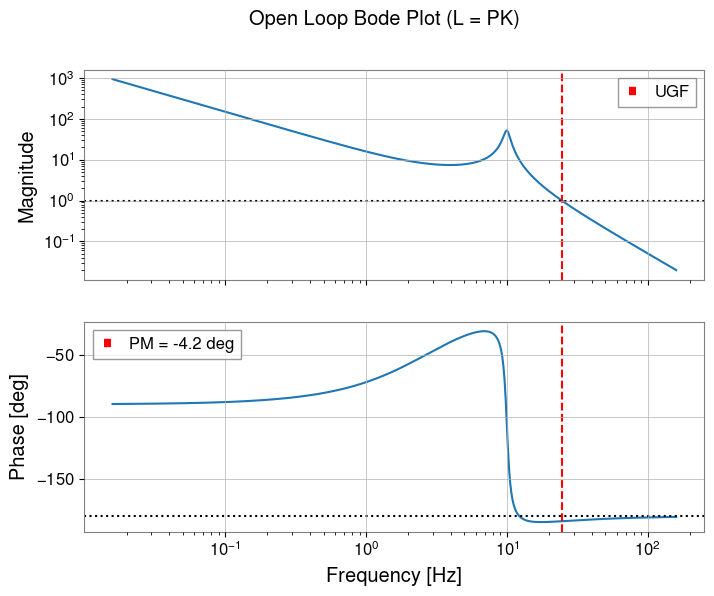

In [4]:
L = P * K_control
T = feedback(L, 1)  # Closed loop transfer function

# Calculate Margins
gm, pm, wg, wp = margin(L)
f_ugf = wp / (2 * np.pi)

print("Final Design:")
print(f"  UGF: {f_ugf:.2f} Hz")
print(f"  Phase Margin: {pm:.2f} deg")

# Plot Open Loop Bode
freqs = logspace(-1, 3, 500)  # 0.1 to 1000 Hz
mag, phase, w = bode(L, freqs, plot=False)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6))
ax1.loglog(w / (2 * np.pi), mag)
ax1.axvline(f_ugf, color="r", linestyle="--", label="UGF")
ax1.axhline(1, color="k", linestyle=":")
ax1.set_ylabel("Magnitude")
ax1.legend()
ax1.grid(True)

ax2.semilogx(w / (2 * np.pi), np.rad2deg(phase))
ax2.axvline(f_ugf, color="r", linestyle="--", label=f"PM = {pm:.1f} deg")
ax2.axhline(-180, color="k", linestyle=":")
ax2.set_ylabel("Phase [deg]")
ax2.set_xlabel("Frequency [Hz]")
ax2.legend()
ax2.grid(True)

plt.suptitle("Open Loop Bode Plot (L = PK)")
plt.show()

## 4. Time Domain Validation

Simulate the step response of the closed-loop system.
We wrap the result in `gwexpy.TimeSeries` for easy plotting.

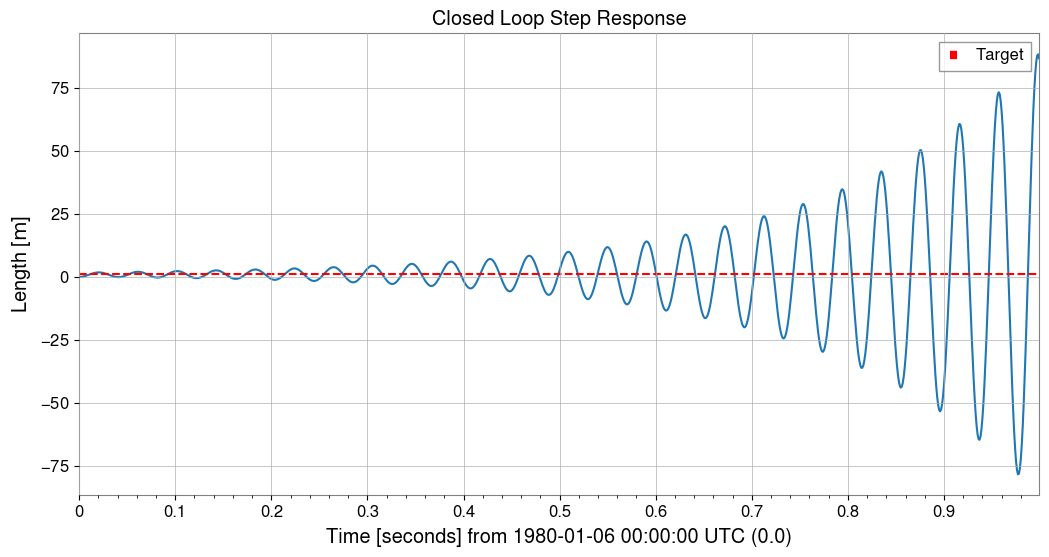

In [5]:
T_sim = 1.0
t_vec = np.arange(0, T_sim, 0.001)
y_step, t_step = step(T, t_vec)

# Wrap in gwexpy TimeSeries
ts_step = TimeSeries(y_step, times=t_step, unit="m", name="Step Response")

# Plot
plot = ts_step.plot()
ax = plot.gca()
ax.axhline(1.0, color="r", linestyle="--", label="Target")
ax.set_title("Closed Loop Step Response")
ax.legend()
plt.show()

In [6]:
# Conclusion
print("Tutorial Series Complete.")
print("1. We measured data and computed ASD/TF.")
print("2. We identified a transfer function model from data.")
print("3. We designed a controller and verified the expected performance.")

Tutorial Series Complete.
1. We measured data and computed ASD/TF.
2. We identified a transfer function model from data.
3. We designed a controller and verified the expected performance.
